# Final Report

**Group 33: Yiran Hou, Uday Kapoor, Kunyue Liu, Christopher Mok**

### (1) Introduction

Diabetes is one of the most common diseases in modern society, which includes a group of conditions in which a patient’s blood sugar level is higher than normal standards. Diabetes raises health problems for hundreds of millions of people around the world every year, including long-term damage, organ breakdown, and organ failure, happening in multiple organs in the body (Arora et al., 2022). Machine Learning, a quickly developing technique, has been frequently studied and applied to the healthcare industry. Researchers have worked on building classifiers to improve diabetes diagnosis at the early stage. The ability to diagnose diabetes early will enable specialists to intervene efficiently in the course of the disease. 

In diagnosing diabetes, modeling methodologies, such as KNN, Decision Tree, Neural Network, Logistic Regression, and SVM, are highly incorporated in the studies (Arora et al., 2022). Many researchers trained the classifiers on the existing datasets and improved their models based on the previous studies. 

We use the Pima Indians Diabetes Database, which includes several predictive factors such as glucose levels, blood pressure, BMI, age, and Diabetes Pedigree Function. This dataset has been frequently used in diabetes prediction research in recent decades. So, to start an early exploration of the dataset, we refer to the results of some existing modeling to investigate essential predictors among all the given features. According to a decision-tree model, which diagnosed type II diabetes, key features involved in the decision nodes are **Glucose, Age, BMI, Diabetes Pedigree Function, and Pregnancy** (Al Jarullah, 2011). From the experiment to build a hybrid intelligence system, researchers especially applied the GA method to feature reduction, capturing essential features, including **Glucose, Age, BMI, and Insulin** (Birla Institute of Technology, Computer Science & Engineering, Mesra, Ranchi, India, et al., 2016). Another study that included feature selection in building the classifier also identified similar results. Based on the F-scores, core features are **Glucose, BMI, Age, Pregnancy, Diabetes Pedigree Function, and Blood Pressure**. After K-Means clustering, the scale is shrunk to the first three features (Gandhi & Prajapati, 2014). 

This study aims to investigate the potential of machine learning algorithms in predicting the risk of diabetes in individuals using a comprehensive dataset of clinical attributes. Specifically, we seek to answer two key questions:

1. **What is the optimal model to predict the likelihood of diabetes based on clinical features considering key accuracy metrics?**
2. **Is adding interaction terms helpful in improving the diagnosis result of the model?**

By applying machine learning techniques, such as **logistic regression, forward selection, and Lasso regression**, we will identify the key variables influencing the outcome and compare the predictive accuracy of the models. Additionally, by answering the proposed questions, this study will contribute to the ongoing efforts in diabetes research, focusing on how machine learning can improve the precision and reliability of diabetes risk prediction.


### (2) Methods and Results

#### (a) Exploratory Data Analysis (EDA)

In [1]:
# Main developer: Chris, Kunyue, Uday, Yiran

install.packages('cowplot')
install.packages('GGally')
install.packages("ROCR") 
install.packages("leaps")
install.packages("corrplot")
install.packages("glmnet")
install.packages('gridExtra')

# # loading the libararies
library(tidyverse)
library(cowplot)
library(GGally)
library(caret)      # For model training and evaluation
library(ggplot2)    # For visualization
library(pROC)       # For ROC and AUC calculation
library(corrplot)
library(ROCR)
library(glmnet)
library(gridExtra)
library(readr)
library(car)
library(dplyr)
library(broom)
library(leaps)
library(tibble)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the c

In [2]:
diabetes_data<-read_csv("data/diabetes.csv")
head(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [3]:
# Main Developer: Uday Kapoor

data_cleaned <- diabetes_data %>%
  mutate(across(c(Glucose, BloodPressure, SkinThickness, Insulin, BMI), ~ifelse(. == 0, NA, .))) %>%
  drop_na()

cat("Number of rows after cleaning: ", nrow(data_cleaned), "\n")
summary(data_cleaned)

Number of rows after cleaning:  392 


  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   : 56.0   Min.   : 24.00   Min.   : 7.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.:21.00  
 Median : 2.000   Median :119.0   Median : 70.00   Median :29.00  
 Mean   : 3.301   Mean   :122.6   Mean   : 70.66   Mean   :29.15  
 3rd Qu.: 5.000   3rd Qu.:143.0   3rd Qu.: 78.00   3rd Qu.:37.00  
 Max.   :17.000   Max.   :198.0   Max.   :110.00   Max.   :63.00  
    Insulin            BMI        DiabetesPedigreeFunction      Age       
 Min.   : 14.00   Min.   :18.20   Min.   :0.0850           Min.   :21.00  
 1st Qu.: 76.75   1st Qu.:28.40   1st Qu.:0.2697           1st Qu.:23.00  
 Median :125.50   Median :33.20   Median :0.4495           Median :27.00  
 Mean   :156.06   Mean   :33.09   Mean   :0.5230           Mean   :30.86  
 3rd Qu.:190.00   3rd Qu.:37.10   3rd Qu.:0.6870           3rd Qu.:36.00  
 Max.   :846.00   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Ou

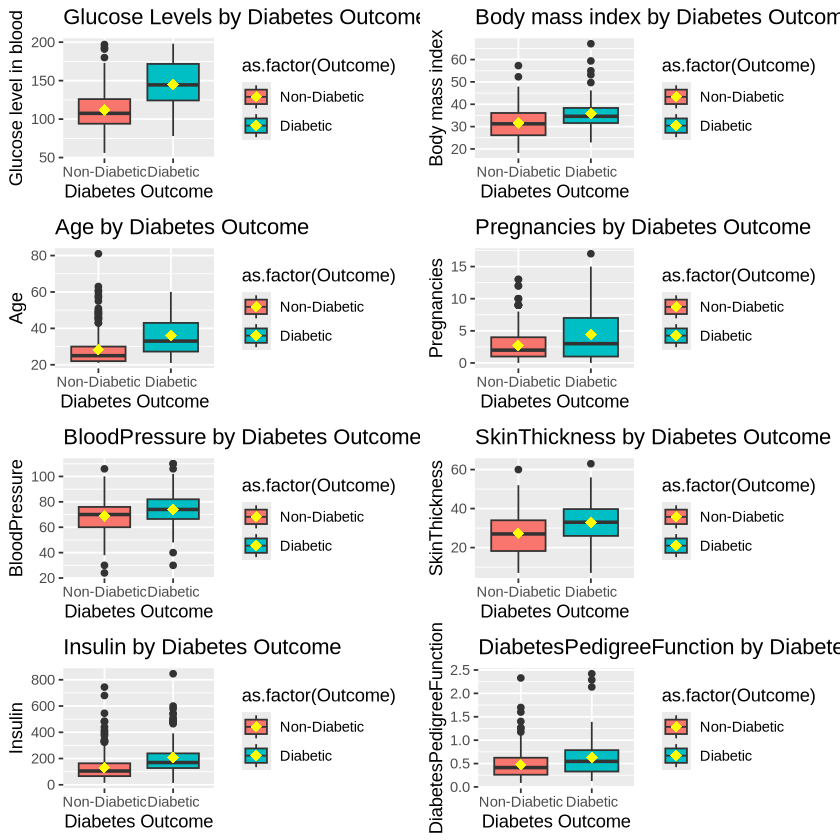

In [4]:
# Main Developer: Yiran Hou

glucose_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Glucose, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Glucose level in blood") + 
    ggtitle("Glucose Levels by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) +  
    stat_summary(aes(x= as.factor(Outcome), y= Glucose, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

bmi_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = BMI, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Body mass index") + 
    ggtitle("Body mass index by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= BMI, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

age_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Age, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Age") + 
    ggtitle("Age by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= Age, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

pregnancies_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Pregnancies, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Pregnancies") + 
    ggtitle("Pregnancies by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) +  
    stat_summary(aes(x= as.factor(Outcome), y= Pregnancies, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

bloodpressure_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = BloodPressure, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("BloodPressure") + 
    ggtitle("BloodPressure by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= BloodPressure, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

skinthickness_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = SkinThickness, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("SkinThickness") + 
    ggtitle("SkinThickness by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= SkinThickness, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

insulin_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = Insulin, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("Insulin") + 
    ggtitle("Insulin by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) + 
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= Insulin, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

diabetesedigreefunction_outcome <- 
    ggplot(data_cleaned, aes(x = as.factor(Outcome), y = DiabetesPedigreeFunction, fill = as.factor(Outcome))) +
    geom_boxplot() +
    xlab("Diabetes Outcome") +
    ylab("DiabetesPedigreeFunction") + 
    ggtitle("DiabetesPedigreeFunction by Diabetes Outcome") +
    scale_x_discrete(labels = c("0" = "Non-Diabetic", "1" = "Diabetic")) +
    scale_fill_discrete(labels = c("Non-Diabetic", "Diabetic")) + 
    stat_summary(aes(x= as.factor(Outcome), y= DiabetesPedigreeFunction, fill = as.factor(Outcome)),
	fun = mean, color = "yellow", geom = "point", shape = 18, size = 3) 

grid.arrange(glucose_outcome,bmi_outcome,
             age_outcome,pregnancies_outcome,
             bloodpressure_outcome,skinthickness_outcome, 
             insulin_outcome, diabetesedigreefunction_outcome, ncol=2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000000,0.1982910,0.2133548,0.0932094,0.07898363,-0.02534728,0.007562116,0.67960847
Glucose,0.198291043,1.0000000,0.2100266,0.1988558,0.58122301,0.20951592,0.140180180,0.34364150
BloodPressure,0.213354775,0.2100266,1.0000000,0.2325712,0.09851150,0.30440337,-0.015971104,0.30003895
SkinThickness,0.093209397,0.1988558,0.2325712,1.0000000,0.18219906,0.66435487,0.160498526,0.16776114
Insulin,0.078983625,0.5812230,0.0985115,0.1821991,1.00000000,0.22639652,0.135905781,0.21708199
BMI,-0.025347276,0.2095159,0.3044034,0.6643549,0.22639652,1.00000000,0.158771043,0.06981380
DiabetesPedigreeFunction,0.007562116,0.1401802,-0.0159711,0.1604985,0.13590578,0.15877104,1.000000000,0.08502911
Age,0.679608470,0.3436415,0.3000389,0.1677611,0.21708199,0.06981380,0.085029106,1.00000000


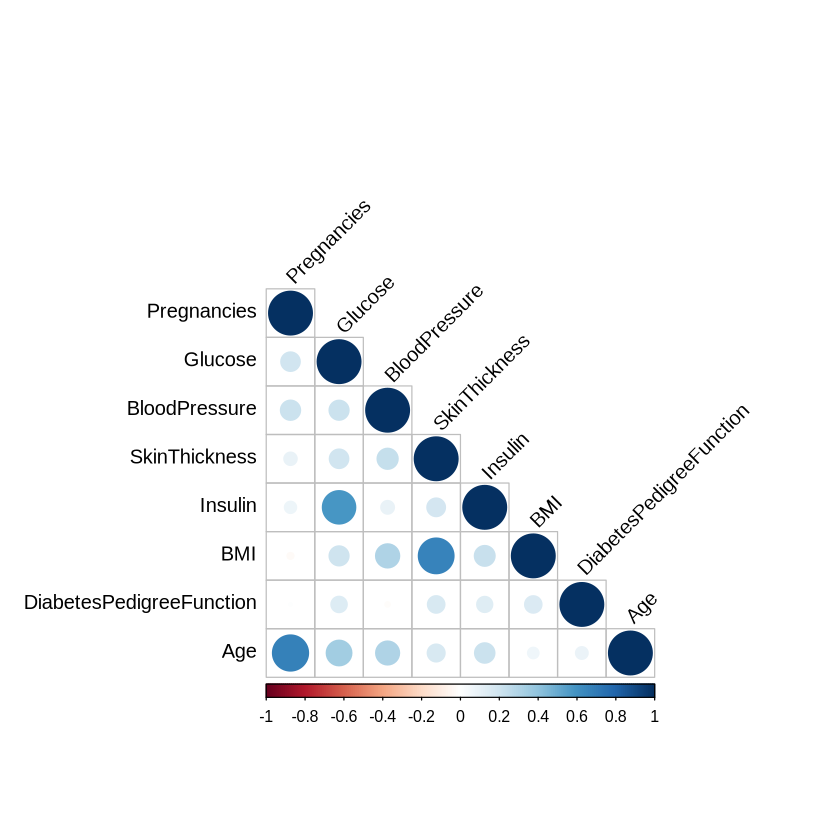

In [5]:
# Main Developer: Uday Kapoor

numeric_vars <- data_cleaned %>% select(-Outcome)
cor_matrix <- cor(numeric_vars)
cor_matrix
corrplot(cor_matrix, method = "circle", type = "lower", tl.col = "black", tl.srt = 45)

In [6]:
# Main Developer: Uday Kapoor

scaled_data <- data_cleaned %>%
  mutate(across(-Outcome, scale))
head(scaled_data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
-0.71651083,-1.0896533,-0.37317791,-0.5843629,-0.5221747,-0.7095143,-1.0305593,-0.9670632,0
-1.02789913,0.4657189,-2.45382847,0.5567094,0.1005024,1.4249091,5.1085822,0.2093178,1
-0.09373423,-1.4460927,-1.65357826,0.2714413,-0.5726620,-0.2968591,-0.7961084,-0.4769045,1
-0.40512253,2.4099341,-0.05307782,1.5076030,3.2559608,-0.3680065,-1.0566094,2.1699528,1
-0.71651083,2.1507054,-0.85332804,-0.5843629,5.8055711,-0.4249245,-0.3619399,2.7581434,1
0.52904237,1.4054229,0.10697222,-0.9647204,0.1594043,-1.0367925,0.1851123,1.9738893,1


#### (b) Methods: Plan 

To answer our research question, “What is the optimal model to predict the likelihood of diabetes based on clinical features, considering key accuracy metrics?”, multiple predictive modeling approaches were employed by different team members. The methods included training and testing data preparation, feature selection, model building, and performance evaluation using accuracy and AUC metrics. We compared models based on their AUC values to identify the model of best fit. All model performance are evaluated using accuracy and the Area Under the Curve (AUC), with an ROC curve plotted for a comprehensive assessment of classification effectiveness.

The dataset was first split into training and testing sets to ensure proper evaluation of the models. The training set was used to fit the models, while the testing set was reserved for evaluating their predictive performance. A random 70/30 split of the dataset was performed using `slice_sample()` for the training set and `anti_join()` for the test set, ensuring no overlap between the two subsets. This split allows unbiased assessment of model performance on unseen data.

In [7]:
# Main developer: Yiran Hou

#training data/testing data
set.seed(123)
diabetes_train <- 
    scaled_data %>% 
    slice_sample(prop = 0.70)

diabetes_test <- 
    scaled_data %>% 
    anti_join(diabetes_train)

Joining with `by = join_by(Pregnancies, Glucose, BloodPressure, SkinThickness,
Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome)`


##### Logistic Regression 1 (model_1)

The first model combines the work from Kunyue and Yiran.  To select the best predictive model, we employed a forward selection approach. Initially, forward selection was applied to test all potential variables in an additive model form using the regsubsets() function. This process evaluated models of different sizes and identified the best model based on the Bayesian Information Criterion (BIC). The results indicated that the optimal model included three variables: glucose, BMI, and age. Building on this, we further evaluated both additive and interactive models using the same three variables to assess whether interaction terms would improve the model's fitness. Forward selection was again applied to both model types, and we compared key metrics such as adjusted $R^2$, BIC, and $C_p$.

In [8]:
# Main developer: Kunyue Liu

subset_selection <- regsubsets(Outcome ~ ., 
                                 data = diabetes_train, 
                                 nvmax = 8, 
                                 method = "forward")
subset_summary <- summary(subset_selection)

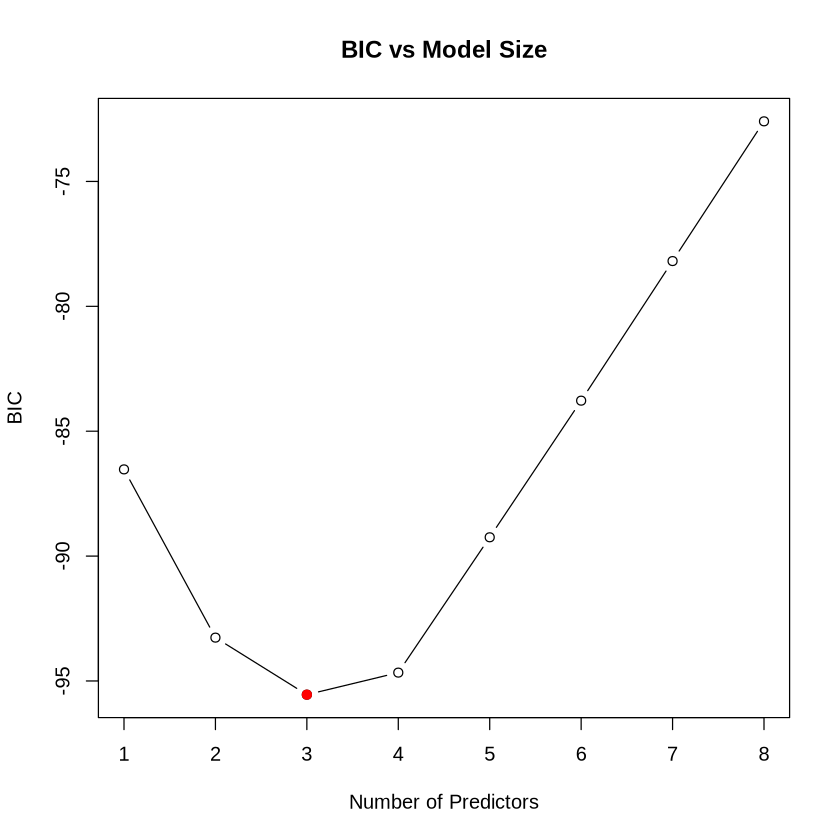

In [9]:
# Main developer: Kunyue Liu

# Plot BIC vs Model Size
plot(subset_summary$bic, type = "b", 
     xlab = "Number of Predictors", 
     ylab = "BIC", 
     main = "BIC vs Model Size")
points(which.min(subset_summary$bic), min(subset_summary$bic), col = "red", pch = 19)

In [10]:
# Main developer: Kunyue Liu

# Retrieve the best variables
best_model_size <- which.min(subset_summary$bic)
best_model_vars <- names(coef(subset_selection, best_model_size))[-1]
best_model_vars

[1] "Glucose" "BMI"     "Age"

In [11]:
# Main developer: Yiran Hou
# Contributor: Kunyue Liu

# Fit additive model
additive_model <- glm(Outcome ~ Glucose + BMI + Age, data = diabetes_train, family = binomial)
interactive_selection <- regsubsets(Outcome ~ Glucose * BMI + Glucose * Age + BMI * Age, 
                                    data = diabetes_train, 
                                    nvmax = 6,
                                    method = "forward")
#just more straightforward for calculating adjR2, BIC, and Cp
additive_selection <- regsubsets(Outcome ~ Glucose + BMI + Age, 
                                 data = diabetes_train, 
                                 nvmax = 3, 
                                 method = "forward")
additive_summary <- summary(additive_selection)
interactive_summary <- summary(interactive_selection)

In [12]:
# Main developer: Yiran Hou

comparison_tibble <- tibble(
  Model = c(rep("Additive", 1), rep("Interactive", 6)), # Only 1 row for Additive (n_input_variables = 3)
  n_input_variables = c(3, 1:6), # Exclude n_input_variables = 1 and 2 for Additive
  Adjusted_R2 = c(additive_summary$adjr2[3], interactive_summary$adjr2),
  BIC = c(additive_summary$bic[3], interactive_summary$bic),
  Cp = c(additive_summary$cp[3], interactive_summary$cp)
)
comparison_tibble

Model,n_input_variables,Adjusted_R2,BIC,Cp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Additive,3,0.3426978,-95.54865,4.000000
Interactive,1,0.2974925,-86.52844,17.890917
Interactive,2,0.3259742,-93.26473,7.203489
Interactive,3,0.3426978,-95.54865,1.384971
Interactive,4,0.3411477,-90.30682,3.022881
Interactive,5,0.3387293,-84.71026,5.006733
Interactive,6,0.3362693,-79.10404,7.000000


According to the results above, the largest adjusted $R^2$ values are found in both the three-variable additive model and the three-variable interactive model, each with a value of 0.343. Similarly, the smallest BIC values are also achieved by the three-variable additive model and the three-variable interactive model, both with a value of -95.549. However, the three-variable additive model has a $C_p$ value closest to 4 (number of variables + 1). Based on these criteria, the **three-variable additive model** is the most suitable choice as it demonstrates the best balance between predictive performance and parsimony. We will call it `model_1` in the following report.

In [13]:
# Main developer: Yiran Hou
# Contributor: Kunyue Liu

model_1 <- glm(Outcome ~ Glucose + BMI + Age, data = diabetes_train, family = binomial) #same as additive_model above ~
tidy_model_1 <- 
        tidy(model_1, conf.int = TRUE) %>%
        mutate(oddsratio = exp(estimate),
               lowerci = exp(conf.low),
               upperci = exp(conf.high)) %>%
        select(term, oddsratio, lowerci, upperci, p.value)
tidy_model_1

term,oddsratio,lowerci,upperci,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3799934,0.2679223,0.5259861,1.659778e-08
Glucose,3.6506397,2.5071783,5.5474641,1.359430e-10
BMI,1.8182983,1.3063972,2.6001244,6.312893e-04
Age,1.5136651,1.1074436,2.0942342,1.024565e-02


In [14]:
# Main developer: Kunyue Liu

# Confusion matrix of the model on testing data
diabetes_pred_class_test <- round(predict(model_1, diabetes_test, type='response'),0)
model_1_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(diabetes_pred_class_test),
    reference = as.factor(diabetes_test$Outcome),
    positive = "1"
)
model_1_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 72 15
         1 11 20
                                          
               Accuracy : 0.7797          
                 95% CI : (0.6941, 0.8507)
    No Information Rate : 0.7034          
    P-Value [Acc > NIR] : 0.04053         
                                          
                  Kappa : 0.4539          
                                          
 Mcnemar's Test P-Value : 0.55630         
                                          
            Sensitivity : 0.5714          
            Specificity : 0.8675          
         Pos Pred Value : 0.6452          
         Neg Pred Value : 0.8276          
             Prevalence : 0.2966          
         Detection Rate : 0.1695          
   Detection Prevalence : 0.2627          
      Balanced Accuracy : 0.7194          
                                          
       'Positive' Class : 1               
                                    

In [15]:
# Main developer: Yiran Hou

# Accuracy
accuracy_1 <- model_1_confusion_matrix$overall["Accuracy"]
cat("Accuracy (Logistic Regression):", accuracy_1, "\n")

# AUC Calculation for Logistic Regression
pred_probs_1 <- predict(model_1, diabetes_test, type = "response")
log_roc_pred <- prediction(pred_probs_1, diabetes_test$Outcome)
log_roc_perf <- performance(log_roc_pred, measure = "tpr", x.measure = "fpr")
auc_log_1 <- performance(log_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Logistic Regression):", auc_log_1, "\n")

Accuracy (Logistic Regression): 0.779661 
AUC (Logistic Regression): 0.8037866 


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = diabetes_test$Outcome, predictor = predict(model_1,     newdata = diabetes_test, type = "response"))

Data: predict(model_1, newdata = diabetes_test, type = "response") in 83 controls (diabetes_test$Outcome 0) < 35 cases (diabetes_test$Outcome 1).
Area under the curve: 0.8038

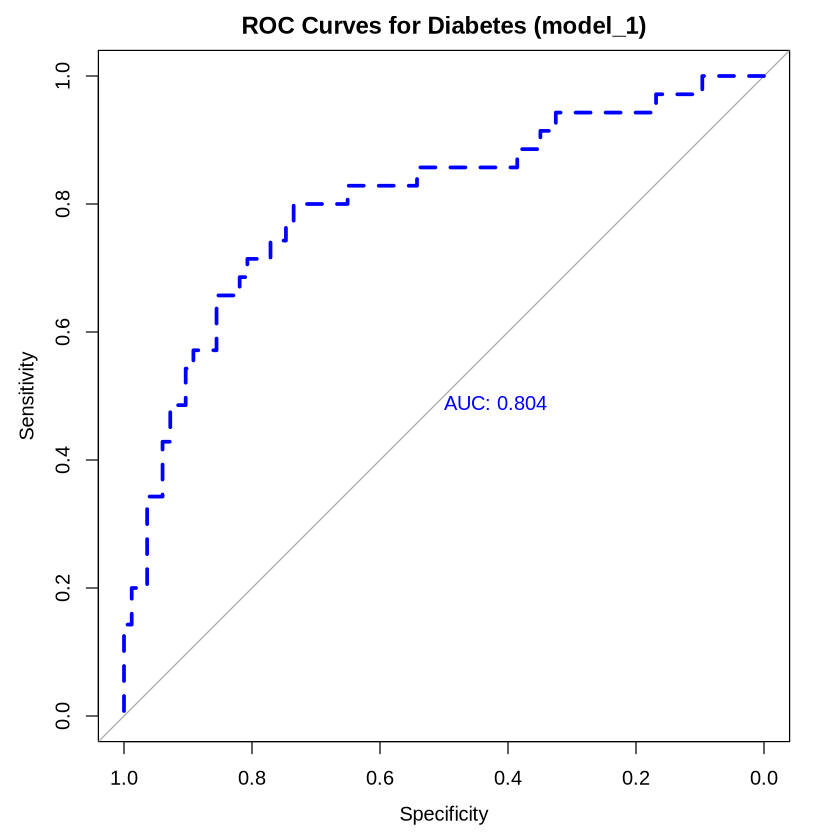

In [16]:
# Main developer: Yiran Hou, Kunyue Liu

roc_curve <- 
    roc(response = diabetes_test$Outcome, 
        predictor = predict(model_1, newdata = diabetes_test, type = "response"))

model_1_auc_plot <- plot(roc_curve,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Diabetes (model_1)"
)
model_1_auc_plot

The best model in Yiran's and Kunyue's individual assignment is an addictive model for Glucose, BMI and Age:
> logit(P(`Outcome`=1)) = −0.968 + 1.297 * `Glucose` + 0.598 * `BMI` + 0.415 * `Age`

##### Logistic Regression 2 (model_2)

The second model is from Christopher, where a logistic regression approach was used to develop and evaluate a predictive model. This model included `Glucose`, `BMI`, and `BloodPressure` as predictors, along with an interaction term for *glucose and BMI*. These variables were firstly chosen based on interest in exploring their relationship with diabetes, rather than through a formal model selection method. However, our reference supports the inclusion of these variables, as they have been shown to be associated with diabetes. Therefore, we decided to include this model in our comparison.

In [18]:
# Main Developer: Christopher Mok

# Convert "Outcome" to a factor to differentiate between categories
diabetes_data$Outcome <- as.factor(diabetes_data$Outcome)

# Estimation: Fit logistic regression model
log_model <- glm(Outcome ~ Glucose + BMI + BloodPressure + Glucose:BMI, data = diabetes_train, family = "binomial") #model_2

# Inference: Summarize model results with odds ratios and confidence intervals
model_summary <- tidy(log_model, exponentiate = TRUE, conf.int = TRUE)
print(model_summary)

# Prediction: Predict outcomes on test data
pred_probs_2 <- predict(log_model, newdata = diabetes_test, type = "response")
pred_classes <- ifelse(pred_probs_2 > 0.5, 1, 0)

# Create confusion matrix
model_2_conf_matrix <- confusionMatrix(as.factor(pred_classes), as.factor(diabetes_test$Outcome), positive = "1")
print(model_2_conf_matrix)

# A tibble: 5 × 7
  term          estimate std.error statistic  p.value conf.low conf.high
  <chr>            <dbl>     <dbl>     <dbl>    <dbl>    <dbl>     <dbl>
1 (Intercept)      0.389     0.174    -5.43  5.53e- 8    0.272     0.540
2 Glucose          4.58      0.216     7.04  1.89e-12    3.08      7.22 
3 BMI              1.90      0.187     3.42  6.15e- 4    1.33      2.78 
4 BloodPressure    0.978     0.177    -0.126 9.00e- 1    0.689     1.38 
5 Glucose:BMI      0.679     0.222    -1.74  8.11e- 2    0.443     1.07 
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 72 15
         1 11 20
                                          
               Accuracy : 0.7797          
                 95% CI : (0.6941, 0.8507)
    No Information Rate : 0.7034          
    P-Value [Acc > NIR] : 0.04053         
                                          
                  Kappa : 0.4539          
                                          
 Mcnemar's Test P-Value

In [19]:
# Main Developer: Christopher Mok

# Accuracy
accuracy_2 <- model_2_conf_matrix$overall["Accuracy"]
cat("Accuracy (Logistic Regression):", accuracy_2, "\n")

# AUC Calculation for Logistic Regression
log_roc_pred <- prediction(pred_probs_2, diabetes_test$Outcome)
log_roc_perf <- performance(log_roc_pred, measure = "tpr", x.measure = "fpr")
auc_log_2 <- performance(log_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Logistic Regression):", auc_log_2, "\n")

Accuracy (Logistic Regression): 0.779661 
AUC (Logistic Regression): 0.7700516 


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = diabetes_test$Outcome, predictor = pred_probs_2)

Data: pred_probs_2 in 83 controls (diabetes_test$Outcome 0) < 35 cases (diabetes_test$Outcome 1).
Area under the curve: 0.7701

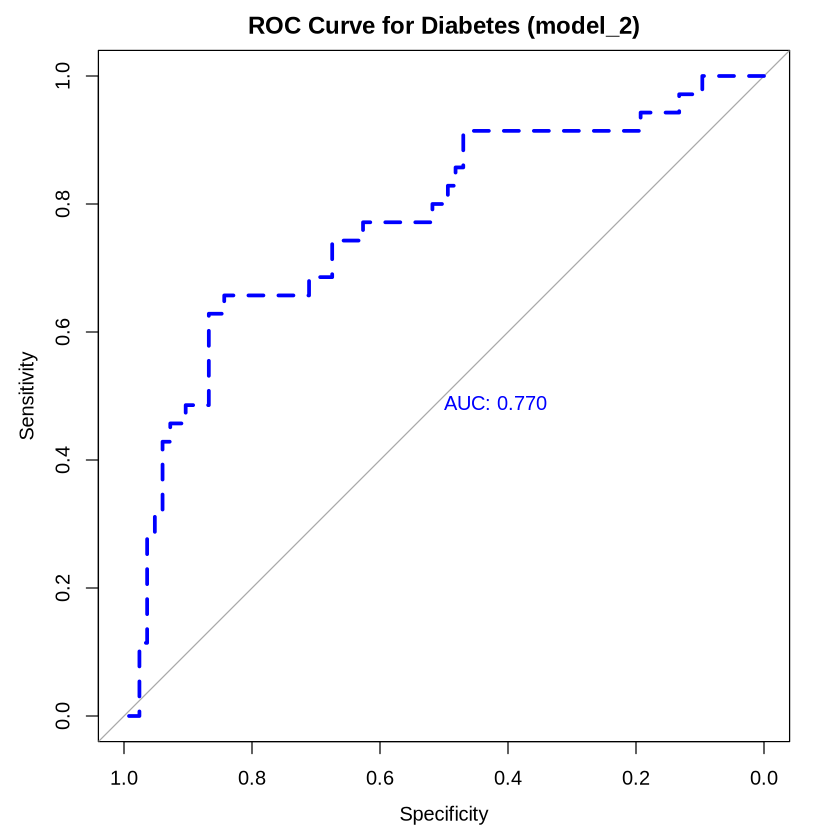

In [21]:
# Main Developer: Christopher Mok

# ROC curve
ROC_full_log_test <- roc(
  response = diabetes_test$Outcome,
  predictor = pred_probs_2
)
model_2_auc_plot <- plot(
  ROC_full_log_test,
  print.auc = TRUE,
  col = "blue",
  lwd = 3,
  lty = 2,
  main = "ROC Curve for Diabetes (model_2)"
)
model_2_auc_plot

The model by Christopher's is an interactive model for Glucose, BMI and Blood Pressure:
> logit(P(`Outcome`=1))= −5.43 + 1.52 * `Glucose` + 0.642 * `BMI` −0.022 * `BloodPressure` −0.385 * (`Glucose` × `BMI`)

##### Lasso Regression (model_3)

The third model is provided by Uday, which employs **Lasso Regression** with cross-validation to identify significant predictors for diabetes while preventing overfitting. The model selects an optimal penalty parameter based on cross-validation. The best set of coefficients is extracted, and predictions are generated on the test set. Binary predictions are made by applying a 0.5 threshold to the predicted probabilities.

Best Lambda for Lasso: 0.01328057 
9 x 1 sparse Matrix of class "dgCMatrix"
                                  s1
(Intercept)              -0.90814218
Pregnancies               .         
Glucose                   1.18105374
BloodPressure             .         
SkinThickness             0.01649035
Insulin                   .         
BMI                       0.44275019
DiabetesPedigreeFunction  0.27898763
Age                       0.33083714
Confusion Matrix (Lasso Regression):
         Actual
Predicted  0  1
        0 75 15
        1  8 20
Accuracy (Lasso Regression): 0.8050847 
AUC (Lasso Regression): 0.8072289 


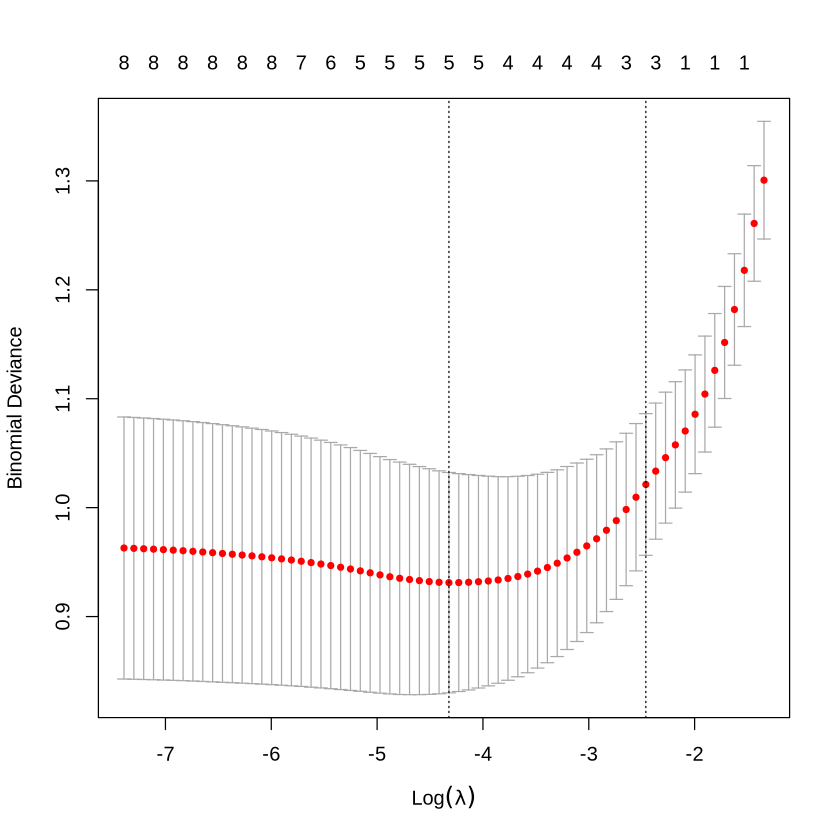

In [22]:
# Main Developer: Uday Kapoor

# Lasso regression model (with cross-validation)
x_train <- as.matrix(diabetes_train %>% select(-Outcome))
y_train <- diabetes_train$Outcome

lasso_model <- cv.glmnet(x_train, y_train, alpha = 1, family = "binomial") #model_3
plot(lasso_model)

# Coefficients at the best lambda
lasso_best_lambda <- lasso_model$lambda.min
cat("Best Lambda for Lasso:", lasso_best_lambda, "\n")
lasso_coefs <- coef(lasso_model, s = "lambda.min")
print(lasso_coefs)

# Predictions and evaluation
x_test <- as.matrix(diabetes_test %>% select(-Outcome))
lasso_pred_prob <- predict(lasso_model, x_test, s = "lambda.min", type = "response")
lasso_pred <- ifelse(lasso_pred_prob > 0.5, 1, 0)
lasso_conf_matrix <- table(Predicted = lasso_pred, Actual = diabetes_test$Outcome)
cat("Confusion Matrix (Lasso Regression):\n")
print(lasso_conf_matrix)

# Accuracy
lasso_accuracy <- sum(diag(lasso_conf_matrix)) / sum(lasso_conf_matrix)
cat("Accuracy (Lasso Regression):", lasso_accuracy, "\n")

# AUC Calculation for Lasso Regression
lasso_roc_pred <- prediction(lasso_pred_prob, diabetes_test$Outcome)
lasso_roc_perf <- performance(lasso_roc_pred, measure = "tpr", x.measure = "fpr")
auc_lasso <- performance(lasso_roc_pred, measure = "auc")@y.values[[1]]
cat("AUC (Lasso Regression):", auc_lasso, "\n")

Setting levels: control = 0, case = 1

Warning message in roc.default(response = diabetes_test$Outcome, predictor = lasso_pred_prob):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases




Call:
roc.default(response = diabetes_test$Outcome, predictor = lasso_pred_prob)

Data: lasso_pred_prob in 83 controls (diabetes_test$Outcome 0) < 35 cases (diabetes_test$Outcome 1).
Area under the curve: 0.8072

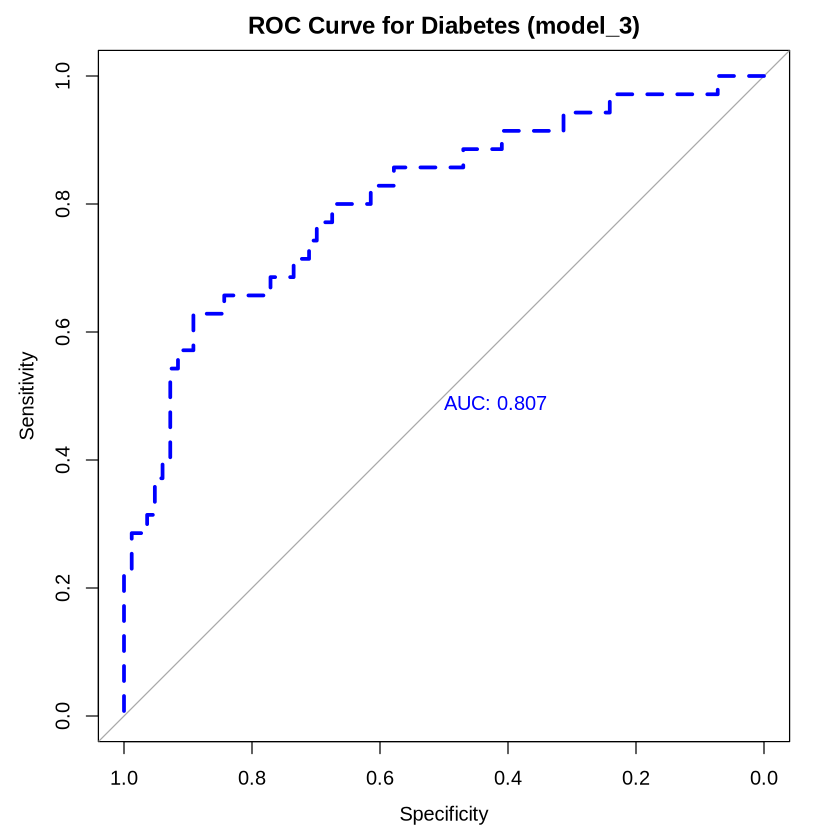

In [23]:
# Main Developer: Yiran Hou

roc_curve <- roc(response = diabetes_test$Outcome, 
                 predictor = lasso_pred_prob)

# Plot the ROC curve
model_3_auc_plot <- 
    plot(
      roc_curve,
      print.auc = TRUE, 
      col = "blue",     
      lwd = 3,  
      lty = 2,
      main = "ROC Curve for Diabetes (model_3)" 
)
model_3_auc_plot

The model by Christopher's is an interactive model for Glucose, BMI and Blood Pressure:
> logit(P(`Outcome`=1))= −0.90288969 + 1.17062220 * `Glucose`+ 0.01332327 * `SkinThickness` + 0.43590406 * `BMI` + 0.26929697 * `DiabetesPedigreeFunction` + 0.32449748 * `Age`

### (3) Discussion

<font color = "blue">
    
- Generate a table that summarize the AUC of the three model above, and choose the one with the largest AUC.
- More on Findings, less on implications, model improvement, and future research direction.

</font>

In [24]:
# Main Developer: Yiran Hou

model_performance <- tibble(
  Model = c("Model 1", "Model 2", "Model 3"),
  Accuracy = c(accuracy_1, accuracy_2, lasso_accuracy),
  AUC = c(auc_log_1, auc_log_2, auc_lasso)             
)
model_performance

Model,Accuracy,AUC
<chr>,<dbl>,<dbl>
Model 1,0.7796610,0.8037866
Model 2,0.7796610,0.7700516
Model 3,0.8050847,0.8072289


#### Summary of Findings

In this analysis, we set out to determine the diagnostic factors most strongly associated with diabetes in a dataset of Pima Indian women. We utilized **Logistic Regression** and **Lasso Regression** models to identify key predictors and assess their effectiveness in predicting the outcome variable, whether the individual has diabetes (binary classification: 0 = no, 1 = yes).

1. **Logistic Regression Results**:
   - **Significant predictors** of diabetes in the logistic regression model include:
     - **Glucose** (p-value < 0.001): Glucose levels are strongly correlated with the likelihood of diabetes. This aligns with known research that high glucose levels are a primary factor in the diagnosis of diabetes.
     - **Diabetes Pedigree Function** (p-value = 0.0232): This measure of family history is another significant predictor, suggesting that genetic predisposition plays a role in diabetes risk.
     - **BMI** (p-value = 0.0668): Though not highly significant (p-value slightly greater than 0.05), BMI also shows a trend suggesting that higher body mass index increases the likelihood of diabetes.
   - **Other variables** like **Pregnancies**, **Blood Pressure**, **Skin Thickness**, and **Insulin** did not show strong significance. For example, insulin had a p-value of 0.4744, indicating that its effect on predicting diabetes was negligible in this dataset, which could be a result of multicollinearity or a data issue (e.g., many zero values).
   - The **AUC** for the logistic regression model was **0.8535**, indicating a good predictive performance. The model's accuracy was 78.21%, meaning it correctly classified 78.21% of the observations, though there is room for improvement, particularly in reducing false positives (12 predicted non-diabetic as diabetic).

2. **Lasso Regression Results**:
   - The **Lasso Regression** model was applied to help identify the most important predictors while also regularizing the coefficients to prevent overfitting.
   - The **Best Lambda** found was **0.0139**, indicating the optimal level of regularization that minimizes model complexity while maintaining predictive performance.
   - Key predictors in the Lasso model are similar to those in the logistic regression model, including **Glucose**, **BMI**, and **Diabetes Pedigree Function**. However, **Blood Pressure** and **Insulin** were excluded from the model due to their coefficients being shrunk to zero, suggesting they are less relevant in predicting diabetes in this dataset.
   - The **AUC** for the Lasso model was **0.8513**, slightly lower than the logistic regression model (0.8535), with an accuracy of **76.92%**. Although the Lasso model has a slightly lower accuracy, it is more robust in handling multicollinearity and can generalize better to unseen data.

#### Implications and Impact

- **Glucose** levels remain the strongest predictor of diabetes in both models, which is consistent with existing medical research that links high blood glucose levels with the onset of diabetes. Therefore, focusing on glucose monitoring and management could be crucial for early detection and prevention.
- **Diabetes Pedigree Function** also plays an important role, indicating that family history is a significant risk factor. This suggests that individuals with a family history of diabetes should be more vigilant in screening and managing potential risk factors.
- The **slightly weaker performance of the Lasso model** highlights that while regularization is helpful for reducing model complexity and preventing overfitting, it may exclude some potentially useful predictors. This suggests a trade-off between interpretability and performance, as models with fewer predictors are easier to explain but might miss out on subtle relationships between variables.
  
#### Model Improvements

While both models showed good predictive performance, there are areas where they can be improved:

1. **Data Preprocessing**:
   - Although we addressed missing values and outliers, additional techniques like **feature scaling** or **normalization** could potentially improve model performance, especially for models like logistic regression that may be sensitive to the scale of the data.
   - Further exploration of **interaction terms** (e.g., interactions between BMI and glucose levels) could reveal more complex relationships in predicting diabetes.
   
2. **Model Tuning**:
   - For the **Lasso model**, fine-tuning the regularization parameter (lambda) using **cross-validation** could provide a more accurate regularization strength.
   - The **Logistic Regression** model can also benefit from more rigorous **hyperparameter tuning** (e.g., adjusting for different interaction terms or polynomial terms).
   
3. **Alternative Models**:
   - Other machine learning models like **Random Forests** or **Support Vector Machines** (SVM) could be explored to improve prediction accuracy. These models may perform better with non-linear relationships and interactions between variables.
   - Additionally, **ensemble methods** (e.g., boosting or bagging) could combine the strengths of multiple models to improve predictive power.

#### Future Research Directions

This study could lead to several interesting follow-up questions and avenues for further research:

1. **Impact of More Variables**:
   - Investigating the inclusion of other health-related features, such as diet, physical activity, or genetic markers, could enhance the model's predictive accuracy.
   
2. **Data Imbalance**:
   - Given that the dataset has a relatively balanced number of diabetic and non-diabetic individuals, future studies could focus on handling imbalanced datasets, especially if we expand to other populations where one class (diabetic or non-diabetic) might be overrepresented.
   
3. **Longitudinal Studies**:
   - Long-term data or longitudinal studies could track the development of diabetes over time. This could help understand how risk factors change and interact over the years and refine early warning systems for diabetes.

4. **Broader Applications**:
   - This model could be adapted for use in clinical settings, assisting healthcare providers in identifying patients at risk of developing diabetes, thus allowing for early intervention strategies and personalized healthcare plans.

In conclusion, both the **Logistic Regression** and **Lasso Regression** models demonstrate that key variables such as **Glucose**, **BMI**, and **Diabetes Pedigree Function** are critical predictors of diabetes in this dataset. While logistic regression shows slightly better performance, the Lasso model offers a more robust framework for handling potential overfitting. Improvements can be made by exploring alternative models, refining the preprocessing steps, and investigating more complex relationships within the data.

### (4) Reference

Arora, N., Singh, A., Al-Dabagh, M. Z. N., & Maitra, S. K. (2022). A Novel Architecture for Diabetes Patients’ Prediction Using K-Means Clustering and SVM. *Mathematical Problems in Engineering, 2022*(1), 4815521. https://doi.org/10.1155/2022/4815521


Al Jarullah, A. A. (2011). Decision tree discovery for the diagnosis of type II diabetes. *2011 International Conference on Innovations in Information Technology*, 303–307. https://doi.org/10.1109/INNOVATIONS.2011.5893838

Birla Institute of Technology, Computer Science & Engineering, Mesra, Ranchi, India, Choubey, D. K., & Paul, S. (2016). GA_MLP NN: A Hybrid Intelligent System for Diabetes Disease Diagnosis. *International Journal of Intelligent Systems and &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Applications, 8*(1), 49–59. https://doi.org/10.5815/ijisa.2016.01.06

Gandhi, K. K., & Prajapati, N. B. (2014). Diabetes prediction using feature selection and classification. *International journal of advance Engineering and Research Development, 1*(05). https://doi.org/10.21090/IJAERD.0105110